In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')
# os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *
from plots import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

c:\Users\USER\Desktop\TrafficTDApython


In [620]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [625]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',

    # 最初的值只有一種
    # '車輛撞擊部位大類別名稱-最初', 
    '車輛撞擊部位大類別名稱-其他',
    
    # 兩個相似且幾乎全部資料都一樣
    # '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',

    # 分析新增的
    # '事故類型及型態子類別名稱'
]
# select_lst = dataA1.columns

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

pass_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '人的狀態']
pass_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '人的狀態']

# drop
pass_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
pass_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

pass_A2 = pass_A2[pass_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
pass_A1 = pass_A1[pass_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
pass_A2 = pass_A2[pass_A2['行動電話或電腦或其他相類功能裝置名稱'] != '不明']
pass_A1 = pass_A1[pass_A1['行動電話或電腦或其他相類功能裝置名稱'] != '不明']

C:\Users\USER\AppData\Local\Temp\ipykernel_33680\4023374890.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_33680\4023374890.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [470]:
# Concat
rbind_data = pd.concat([pass_A1, pass_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)
# rbind_data['速限_int'] = rbind_data['速限-第1當事者']
# rbind_data['年齡_int'] = rbind_data['當事者事故發生時年齡']

bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (3117, 114)


篩選掉未紀錄資料以及分類人的狀態以及車的狀態

由於人的狀態資料量已經很少，所以不進行下採樣

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.124         3.75%                      3.75%
1              0.092         2.78%                      6.53%
2              0.086         2.59%                      9.12%
3              0.077         2.32%                     11.44%
4              0.071         2.14%                     13.58%
5              0.061         1.85%                     15.43%
6              0.058         1.74%                     17.17%
7              0.056         1.71%                     18.88%
8              0.055         1.65%                     20.53%
9              0.054         1.62%                     22.15%
10             0.052         1.56%                     23.71%
11             0.050         1.52%                     25.23%


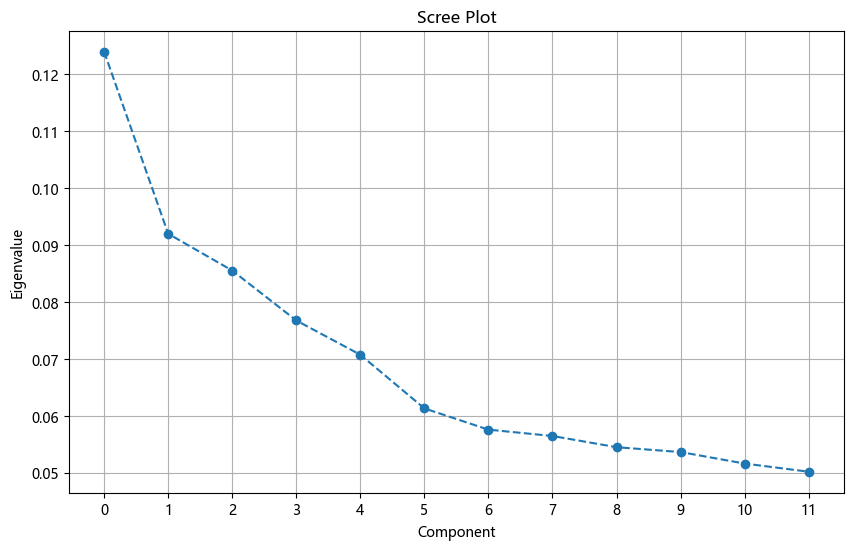

In [74]:
import prince

mca = prince.MCA(
    one_hot=False,
    n_components=12,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [75]:
import seaborn as sns
from matplotlib.font_manager import FontProperties
# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

from matplotlib.cm import get_cmap
from plots import *

In [ ]:
import matplotlib.cm as cm

col_coordinate = mca.column_coordinates(data_to_map)

plt.rcParams['font.family'] = 'Microsoft YaHei'
col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))

plt.gca().set_facecolor('#b55a1d')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

In [77]:
import pickle

detailed_results = []

for overlap in range(1, 6):
    silhouette_for_intervals = []

    for interval in range(2, 11):
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=1
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o{overlap}i{interval}.pkl"
            # filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 1, interval: 2


Processing Clusters: 100%|██████████| 63/63 [00:00<00:00, 360.96it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o1i2.pkl
overlap: 1, interval: 3


Processing Clusters: 100%|██████████| 187/187 [00:00<00:00, 1398.09it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o1i3.pkl
overlap: 1, interval: 4


Processing Clusters: 100%|██████████| 261/261 [00:00<00:00, 1895.99it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o1i4.pkl
overlap: 1, interval: 5


Processing Clusters: 100%|██████████| 467/467 [00:00<00:00, 2675.24it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o1i5.pkl
overlap: 1, interval: 6


Processing Clusters: 100%|██████████| 555/555 [00:00<00:00, 3074.98it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o1i6.pkl
overlap: 1, interval: 7


Processing Clusters: 100%|██████████| 598/598 [00:00<00:00, 3612.08it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o1i7.pkl
overlap: 1, interval: 8


Processing Clusters: 100%|██████████| 850/850 [00:00<00:00, 3964.05it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o1i8.pkl
overlap: 1, interval: 9


Processing Clusters: 100%|██████████| 964/964 [00:00<00:00, 4392.91it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o1i9.pkl
overlap: 1, interval: 10


Processing Clusters: 100%|██████████| 945/945 [00:00<00:00, 5121.74it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o1i10.pkl
overlap: 2, interval: 2


Processing Clusters: 100%|██████████| 45/45 [00:00<00:00, 143.97it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o2i2.pkl
overlap: 2, interval: 3


Processing Clusters: 100%|██████████| 140/140 [00:00<00:00, 646.89it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o2i3.pkl
overlap: 2, interval: 4


Processing Clusters: 100%|██████████| 192/192 [00:00<00:00, 977.08it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o2i4.pkl
overlap: 2, interval: 5


Processing Clusters: 100%|██████████| 318/318 [00:00<00:00, 1469.34it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o2i5.pkl
overlap: 2, interval: 6


Processing Clusters: 100%|██████████| 408/408 [00:00<00:00, 1876.69it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o2i6.pkl
overlap: 2, interval: 7


Processing Clusters: 100%|██████████| 458/458 [00:00<00:00, 2308.00it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o2i7.pkl
overlap: 2, interval: 8


Processing Clusters: 100%|██████████| 619/619 [00:00<00:00, 2443.53it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o2i8.pkl
overlap: 2, interval: 9


Processing Clusters: 100%|██████████| 753/753 [00:00<00:00, 3056.72it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o2i9.pkl
overlap: 2, interval: 10


Processing Clusters: 100%|██████████| 743/743 [00:00<00:00, 3530.31it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o2i10.pkl
overlap: 3, interval: 2


Processing Clusters: 100%|██████████| 35/35 [00:00<00:00, 96.15it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o3i2.pkl
overlap: 3, interval: 3


Processing Clusters: 100%|██████████| 92/92 [00:00<00:00, 229.45it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o3i3.pkl
overlap: 3, interval: 4


Processing Clusters: 100%|██████████| 143/143 [00:00<00:00, 462.47it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o3i4.pkl
overlap: 3, interval: 5


Processing Clusters: 100%|██████████| 215/215 [00:00<00:00, 693.17it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o3i5.pkl
overlap: 3, interval: 6


Processing Clusters: 100%|██████████| 289/289 [00:00<00:00, 1233.07it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o3i6.pkl
overlap: 3, interval: 7


Processing Clusters: 100%|██████████| 330/330 [00:00<00:00, 1538.99it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o3i7.pkl
overlap: 3, interval: 8


Processing Clusters: 100%|██████████| 441/441 [00:00<00:00, 1687.71it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o3i8.pkl
overlap: 3, interval: 9


Processing Clusters: 100%|██████████| 534/534 [00:00<00:00, 2020.48it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o3i9.pkl
overlap: 3, interval: 10


Processing Clusters: 100%|██████████| 584/584 [00:00<00:00, 2556.72it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o3i10.pkl
overlap: 4, interval: 2


Processing Clusters: 100%|██████████| 25/25 [00:00<00:00, 57.10it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o4i2.pkl
overlap: 4, interval: 3


Processing Clusters: 100%|██████████| 68/68 [00:00<00:00, 110.86it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o4i3.pkl
overlap: 4, interval: 4


Processing Clusters: 100%|██████████| 99/99 [00:00<00:00, 180.81it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o4i4.pkl
overlap: 4, interval: 5


Processing Clusters: 100%|██████████| 161/161 [00:00<00:00, 345.68it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o4i5.pkl
overlap: 4, interval: 6


Processing Clusters: 100%|██████████| 203/203 [00:00<00:00, 667.35it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o4i6.pkl
overlap: 4, interval: 7


Processing Clusters: 100%|██████████| 253/253 [00:00<00:00, 943.04it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o4i7.pkl
overlap: 4, interval: 8


Processing Clusters: 100%|██████████| 318/318 [00:00<00:00, 1250.39it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o4i8.pkl
overlap: 4, interval: 9


Processing Clusters: 100%|██████████| 386/386 [00:00<00:00, 1500.13it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o4i9.pkl
overlap: 4, interval: 10


Processing Clusters: 100%|██████████| 436/436 [00:00<00:00, 1832.63it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o4i10.pkl
overlap: 5, interval: 2


Processing Clusters: 100%|██████████| 17/17 [00:00<00:00, 23.51it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o5i2.pkl
overlap: 5, interval: 3


Processing Clusters: 100%|██████████| 38/38 [00:00<00:00, 55.06it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o5i3.pkl
overlap: 5, interval: 4


Processing Clusters: 100%|██████████| 65/65 [00:00<00:00, 127.29it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o5i4.pkl
overlap: 5, interval: 5


Processing Clusters: 100%|██████████| 97/97 [00:00<00:00, 233.78it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o5i5.pkl
overlap: 5, interval: 6


Processing Clusters: 100%|██████████| 136/136 [00:00<00:00, 325.45it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o5i6.pkl
overlap: 5, interval: 7


Processing Clusters: 100%|██████████| 162/162 [00:00<00:00, 607.70it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o5i7.pkl
overlap: 5, interval: 8


Processing Clusters: 100%|██████████| 217/217 [00:00<00:00, 796.89it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o5i8.pkl
overlap: 5, interval: 9


Processing Clusters: 100%|██████████| 260/260 [00:00<00:00, 1018.23it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o5i9.pkl
overlap: 5, interval: 10


Processing Clusters: 100%|██████████| 301/301 [00:00<00:00, 1098.25it/s]

Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/results_o5i10.pkl


In [79]:
detailed_results_df = pd.DataFrame(detailed_results)

output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Component12Pass/full_grid.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(detailed_results_df, f)

In [238]:
rbind_data.columns

Index(['發生年度', '發生日期', '發生時間', '事故類別名稱', '處理單位名稱警局層', '發生地點', '天候名稱', '光線名稱',
       '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱', '事故位置大類別名稱',
       '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱',
       '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '當事者順位',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態子類別名稱', '車輛撞擊部位大類別名稱-最初',
       '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他', '肇因研判大類別名稱-個別',
       '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '經度', '緯度', '死亡', '受傷', '速限_int',
       '年齡_int'],
      dtype='object')

Mapper plot created.
Data extracted.
Colors mapped using predefined mapping.
Plot saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Pass/o4_i8_肇因研判子類別名稱-個別.png


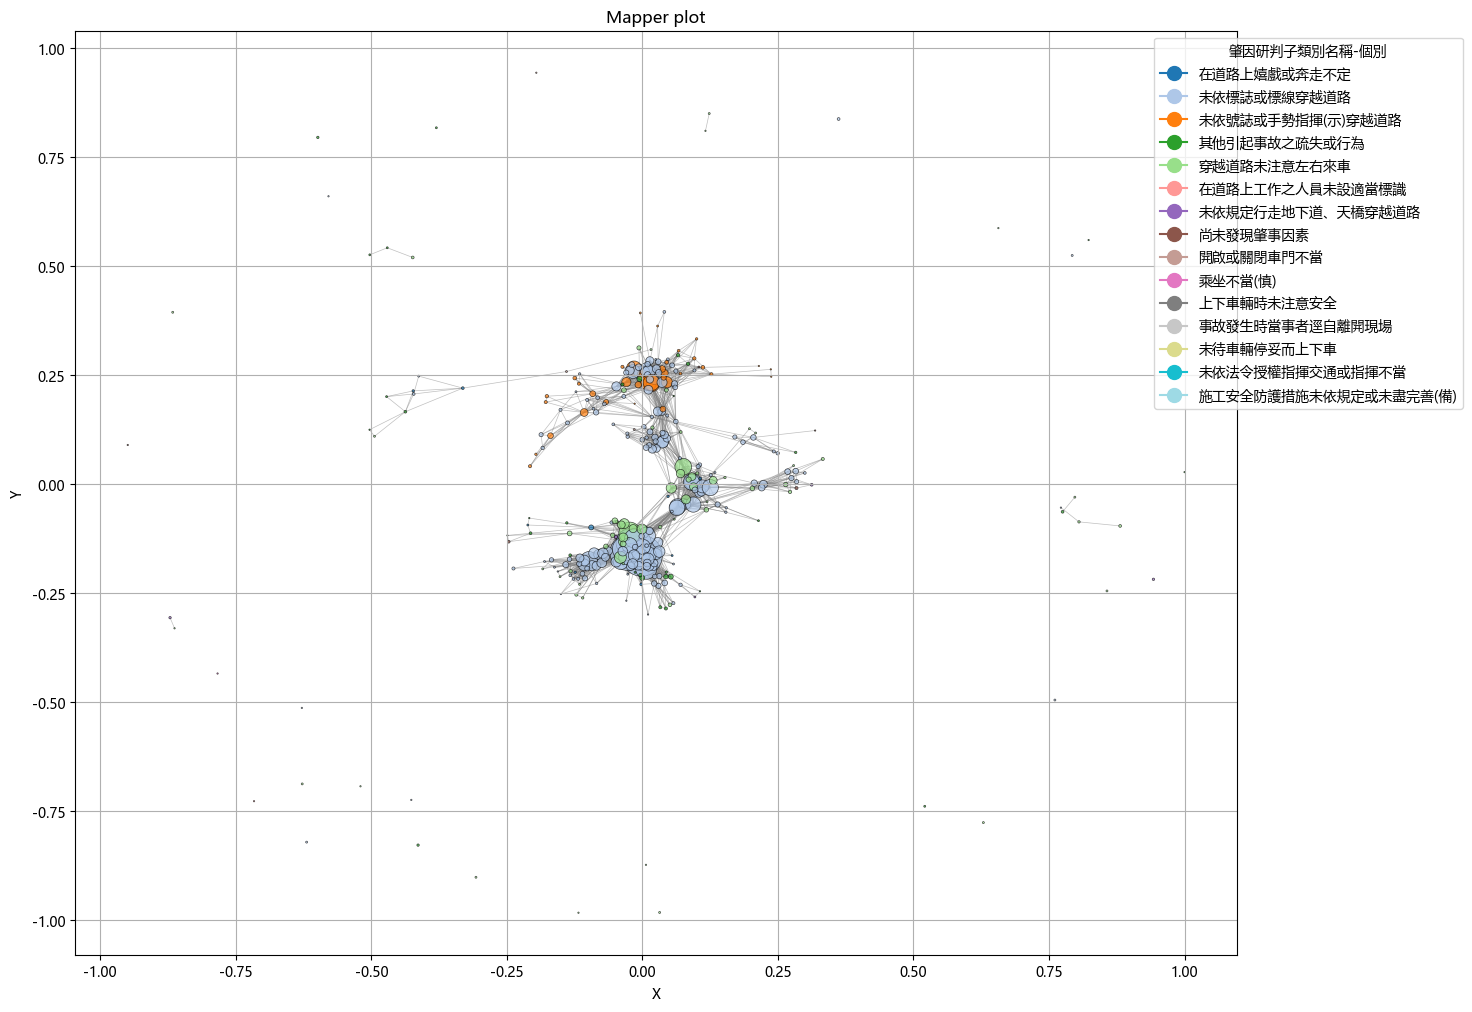

In [256]:
choose = '肇因研判子類別名稱-個別'
# choose = '年齡_int'

unique_categories = rbind_data[choose].dropna().unique()
# 統一顏色
color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[33][0], 
                            rbind_data, detailed_results_df)
mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, color_mapping_fixed, size=0) # 篩選資料
mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                    set_label=True, size=100000, # 限制點的大小
                    save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Pass/o4_i8_{choose}.png")

In [ ]:
choose = 'Cluster'
# choose = '死亡'

unique_categories = rbind_data[choose].unique()
# unique_categories.sort()

for index in range(detailed_results_df.shape[0]):
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], 
                                rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=0)
    mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                        set_label=False, size=100000,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Pass/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")

In [276]:
lst = ['天候名稱', '光線名稱',
       '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱', '事故位置大類別名稱',
       '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱',
       '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態子類別名稱', '車輛撞擊部位大類別名稱-最初',
       '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他', '肇因研判大類別名稱-個別',
       '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '死亡', '受傷']

In [ ]:
for choose in lst:
    unique_categories = rbind_data[choose].dropna().unique()
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[23][0], 
                                rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=0) # 篩選資料
    mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                        set_label=True, size=100000, # 限制點的大小
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Pass/o3_i7_{choose}.png")

In [90]:
from kmodes.kmodes import KModes

data_for_kmode = rbind_data.drop(['死亡', '受傷', 'color_for_plot'], axis=1)

print(data_for_kmode.columns)

cost = []
all_results = {}
K = range(1, 10)

for k in K:
    
    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=5
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

Best run was number 1
Best run was number 1
Best run was number 6
Best run was number 8
Best run was number 9
Best run was number 8
Best run was number 9
Best run was number 1
Best run was number 2


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [627]:
# pd.Series(all_results[4]['labels']).value_counts()

rbind_data['Cluster'] = all_results[4]['labels']

In [ ]:
# attr = '號誌-號誌種類名稱'
attr = '事故位置大類別名稱'

plt.rcParams['font.family'] = 'Microsoft YaHei'
col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

plt.figure(figsize=(14, 8))
sns.countplot(
    data=rbind_data,
    x=attr,
    hue='Cluster',  # 按 Cluster 分组显示
    order=rbind_data[attr].value_counts().index,  # 按频率排序
    palette="tab10"
)
plt.title(f"'{attr}'")
plt.xlabel(f"{attr}")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# DBSCAN 分析

In [ ]:
choose = '天候名稱'
# choose = '年齡_int'

unique_categories = rbind_data[choose].dropna().unique()
# 統一顏色
color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[24][0], 
                            rbind_data, detailed_results_df)
mplot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
full_info = mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, color_mapping_fixed, size=0) # 篩選資料
mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                    set_label=True, size=100000)

In [ ]:
# give me a dbscan using the info
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.034, min_samples=5)
dbscan.fit(full_info[['x', 'y']])
full_info['label'] = dbscan.labels_

# plot using info, color by Cluster
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=full_info,
    x='x',
    y='y',
    hue='label',
    palette="tab10"
)
plt.show()

In [565]:
# x = vars(mplot._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
# y = vars(mplot._MapperLayoutInteractive__fig)['_data_objs'][1]['y']

# threeDimData = pd.DataFrame({'x': x, 'y': y})

# import re
# data_tuple = vars(mplot._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

# data = []
# for item in data_tuple:
#     color = int(re.search(r'color: (-?\d+)', item).group(1))
#     node = int(re.search(r'node: (\d+)', item).group(1))
#     size = int(re.search(r'size: (\d+)', item).group(1))
#     data.append({'color': color, 'node': node, 'size': size})
# component_info = pd.DataFrame(data)

# full_info = pd.concat([component_info, threeDimData], axis=1)

# mp_content_origin = vars(mplot._MapperLayoutInteractive__graph)['_node']

# mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
# mp_content.reset_index(inplace=True)
# mp_content.rename(columns={'index': 'node'}, inplace=True)

# full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [607]:
def get_unique_ids(input_data):
    unique_ids = set()
    for ids_list in input_data['ids']:
        unique_ids.update(ids_list)
    return list(unique_ids)

label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_2 = full_info[full_info['label'] == 2]
label_3 = full_info[full_info['label'] == 3]
label_out = full_info[(full_info['label'] != 0) & (full_info['label'] != 1) & (full_info['label'] != 2) & (full_info['label'] != 3)]
# 確認所有資料都被獲取
assert label_out.shape[0] + label_0.shape[0] + label_1.shape[0] + label_2.shape[0] + label_3.shape[0] == full_info.shape[0]

# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_3 = get_unique_ids(label_3)
count_out = get_unique_ids(label_out)

full_0 = dummy_data.loc[count_0]
full_1 = dummy_data.loc[count_1]
full_2 = dummy_data.loc[count_2]
full_3 = dummy_data.loc[count_3]
full_out = dummy_data.loc[count_out]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0])
print(dummy_data.shape[0])

3019
3117


In [614]:
full_3['死亡'].value_counts()

0    119
1      1
Name: 死亡, dtype: int64

In [572]:
def get_train_test_data(input_data):

    input_data['y'] = input_data.apply(lambda row: 1 if row['死亡'] == 1 or (row['死亡'] == 0 and row['受傷'] > 1) else 0, axis=1)
    input_data.drop(columns=['受傷', '死亡'], inplace=True)
    
    X = input_data.drop(columns=['y'])
    y = input_data['y']

    return X, y

def get_metrics(input_data):

    X, y = get_train_test_data(input_data)

    metrics_log, accuracy_log, conf_matrix_log = logistic_cm_gridsearch(X, y)
    metrics_rf, accuracy_rf, conf_matrix_rf, best_params_rf = random_forest_dummy_classifier(X, y)

    full_metrics = {
        'logistic': {
            'metrics': metrics_log,
            'accuracy': accuracy_log,
            'conf_matrix': conf_matrix_log,
        },
        'random_forest': {
            'metrics': metrics_rf,
            'accuracy': accuracy_rf,
            'conf_matrix': conf_matrix_rf,
            'best_params': best_params_rf
        }
    }

    return full_metrics

In [573]:
return_1 = get_metrics(full_0)
return_2 = get_metrics(full_1)
return_3 = get_metrics(full_2)
return_4 = get_metrics(full_3)
return_out = get_metrics(full_out)

c:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.

c:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.

c:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to i

In [599]:
conf_matrixs = {
    "return_1": return_1['logistic']['conf_matrix'],
    "return_2": return_2['logistic']['conf_matrix'],
    "return_3": return_3['logistic']['conf_matrix'],
    "return_4": return_4['logistic']['conf_matrix'],
    "return_out": return_out['logistic']['conf_matrix']
}

In [605]:
total_conf_matrix = np.zeros_like(next(iter(conf_matrixs.values())))
for matrix in conf_matrixs.values():
    total_conf_matrix += matrix

# 計算準確率
TP = total_conf_matrix[0, 0]  # True Positives
TN = total_conf_matrix[1, 1]  # True Negatives
total = total_conf_matrix.sum()  # 總樣本數

accuracy = (TP + TN) / total

# 結果
accuracy

0.545755237045204